In [1]:
# Environment setup  
import subprocess  
import pyspark
import dxpy  
import dxdata  
import pandas as pd  
import os  
import glob
import pyspark.pandas as ps

# for stats
import databricks.koalas as ks
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

[root] WARNING: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
[root] WARNING: Found pyspark version "3.2.3" installed. The pyspark version 3.2 and above has a built-in "pandas APIs on Spark" module ported from Koalas. Try `import pyspark.pandas as ps` instead. 


In [2]:
# Initialize Spark  
# Spark initialization (Done only once; do not rerun this cell unless you select Kernel -> Restart kernel).  
sc = pyspark.SparkContext()  
spark = pyspark.sql.SparkSession(sc)

In [3]:
# Automatically discover dispensed dataset ID and load the dataset
dispensed_dataset = dxpy.find_one_data_object(
    typename="Dataset", 
    name="app*.dataset", 
    folder="/", 
    name_mode="glob")
dispensed_dataset_id = dispensed_dataset["id"]
dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [4]:
participant = dataset['participant']

In [5]:
# load cohorts from cohort browser  
case = dxdata.load_cohort("/HTN_ICD10/ICD10_HTN_Cases")  
cont = dxdata.load_cohort("/HTN_ICD10/ICD10_HTN_Control")

In [6]:
# Specify fields ID to retrieve, get corresponding UKB RAP field names and print description table.  
field_ids = ['31', '21001', '21022', '21000', '20116', '22189', '4080', '4079', '6177', '30900']

In [7]:
# This function is used to grab all field names (e.g. "p<field_id>_iYYY_aZZZ") of a list of field IDs  
def fields_for_id(field_id):
    from distutils.version import LooseVersion
    field_id = str(field_id)
    fields = participant.find_fields(name_regex=r'^p{}(_i\d+)?(_a\d+)?$'.format(field_id))
    return sorted(fields, key=lambda f: LooseVersion(f.name))

fields = [fields_for_id(f)[0] for f in field_ids] + [participant.find_field(name='p20160_i0')] + [participant.find_field(name='eid')]  
field_description = pd.DataFrame({
    'Field': [f.name for f in fields],
    'Title': [f.title for f in fields],
    'Coding': [f.coding.codes if f.coding is not None else '' for f in fields ]
})  
field_description

/tmp/ipykernel_320/3851626384.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return sorted(fields, key=lambda f: LooseVersion(f.name))


,Field,Title,Coding
0,p31,Sex,"{'0': 'Female', '1': 'Male'}"
1,p21001_i0,Body mass index (BMI) | Instance 0,
2,p21022,Age at recruitment,
3,p21000_i0,Ethnic background | Instance 0,"{'1': 'White', '1001': 'British', '1002': 'Iri..."
4,p20116_i0,Smoking status | Instance 0,"{'-3': 'Prefer not to answer', '0': 'Never', '..."
5,p22189,Townsend deprivation index at recruitment,
6,p4080_i0_a0,"Systolic blood pressure, automated reading | I...",
7,p4079_i0_a0,"Diastolic blood pressure, automated reading | ...",
8,p6177_i0,"Medication for cholesterol, blood pressure or ...","{'1': 'Cholesterol lowering medication', '2': ..."
9,p30900_i0,Number of proteins measured | Instance 0,


In [8]:
# Retrieve fields for the 'case' dataset and convert the result to a pandas DataFrame  
case_df = participant.retrieve_fields(
    fields=fields, # Specify the fields to retrieve
    filter_sql=case.sql, # Apply the SQL filter for the 'case' dataset
    coding_values='replace', #TEXT NOT NUMBERS
    engine=dxdata.connect() # Connect to the data engine
).toPandas() # Convert the result to a pandas DataFrame

In [9]:
# check
print(case_df.head())

      p31  p21001_i0  p21022 p21000_i0 p20116_i0  p22189  p4080_i0_a0  \
0  Female    22.9684      68   British     Never   -5.65          NaN   
1  Female    51.3380      50   British     Never    8.60        120.0   
2  Female    29.3772      55   British  Previous   -1.34        141.0   
3    Male    31.7521      60   British     Never   -5.45        147.0   
4    Male    26.9388      69   British  Previous   -2.15        165.0   

   p4079_i0_a0                                           p6177_i0  p30900_i0  \
0          NaN                                               None        NaN   
1         81.0                                               None        NaN   
2         89.0                                               None        NaN   
3         82.0  [Cholesterol lowering medication, Blood pressu...        NaN   
4         92.0                                [None of the above]        NaN   

  p20160_i0      eid  
0        No  1000189  
1        No  1000399  
2       Yes

In [10]:
# Retrieve fields for the 'cont' dataset and convert the result to a pandas DataFrame  
cont_df = participant.retrieve_fields(
    fields=fields, # Specify the fields to retrieve
    filter_sql=cont.sql, # Apply the SQL filter for the 'cont' dataset
    coding_values='replace', #TEXT NOT NUMBERS
    engine=dxdata.connect(
        dialect="hive+pyspark", # Use Hive with PySpark dialect for the connection
        connect_args={
            'config': {
                'spark.kryoserializer.buffer.max': '256m', # Set the maximum buffer size for Kryo serialization
                'spark.sql.autoBroadcastJoinThreshold': '-1' # Disable auto broadcast join threshold
            }
        }
    ) # Connect to the data engine with specified configurations  
).toPandas() # Convert the result to a pandas DataFrame

In [11]:
# check
print(cont_df.head())

      p31  p21001_i0  p21022 p21000_i0 p20116_i0  p22189  p4080_i0_a0  \
0    Male    22.4393      62   British     Never    0.87        135.0   
1  Female    27.2545      63   British     Never   -3.49        142.0   
2  Female    19.7754      62   British     Never   -4.50        107.0   
3    Male    26.3224      58   British   Current   -3.78        138.0   
4    Male    34.3256      61   British   Current   -1.13        136.0   

   p4079_i0_a0             p6177_i0  p30900_i0 p20160_i0      eid  
0         81.0  [None of the above]        NaN        No  1000104  
1         84.0                 None        NaN        No  1000146  
2         57.0                 None     2920.0        No  1000172  
3         80.0  [None of the above]        NaN       Yes  1000254  
4         74.0  [None of the above]        NaN       Yes  1000273  


In [12]:
# Concatenate the case_df and cont_df DataFrames  
df = pd.concat([case_df, cont_df])

In [13]:
# Get the shape of the DataFrame  
df.shape

(502137, 12)

In [14]:
# check
print(df.head())

      p31  p21001_i0  p21022 p21000_i0 p20116_i0  p22189  p4080_i0_a0  \
0  Female    22.9684      68   British     Never   -5.65          NaN   
1  Female    51.3380      50   British     Never    8.60        120.0   
2  Female    29.3772      55   British  Previous   -1.34        141.0   
3    Male    31.7521      60   British     Never   -5.45        147.0   
4    Male    26.9388      69   British  Previous   -2.15        165.0   

   p4079_i0_a0                                           p6177_i0  p30900_i0  \
0          NaN                                               None        NaN   
1         81.0                                               None        NaN   
2         89.0                                               None        NaN   
3         82.0  [Cholesterol lowering medication, Blood pressu...        NaN   
4         92.0                                [None of the above]        NaN   

  p20160_i0      eid  
0        No  1000189  
1        No  1000399  
2       Yes

In [15]:
# Initialize a new column called 'HTN_cc' in the DataFrame 'df' with all values set to 0  
df['HTN_cc'] = 0

In [16]:
# Update the 'HTN_cc' column to 1 for rows where the 'eid' in 'df' is found in 'case_df'  
df.loc[df.eid.isin(case_df.eid), 'HTN_cc'] = 1

In [17]:
# Count the occurrences of each unique value in the 'HTN_cc' column  
HTN_cc_counts = df.HTN_cc.value_counts()  
print(HTN_cc_counts)

0    339876
1    162261
Name: HTN_cc, dtype: int64


In [18]:
df

,p31,p21001_i0,p21022,p21000_i0,p20116_i0,p22189,p4080_i0_a0,p4079_i0_a0,p6177_i0,p30900_i0,p20160_i0,eid,HTN_cc
0,Female,22.9684,68,British,Never,-5.65,NaN,NaN,None,NaN,No,1000189,1
1,Female,51.3380,50,British,Never,8.60,120.0,81.0,None,NaN,No,1000399,1
2,Female,29.3772,55,British,Previous,-1.34,141.0,89.0,None,NaN,Yes,1000561,1
3,Male,31.7521,60,British,Never,-5.45,147.0,82.0,"[Cholesterol lowering medication, Blood pressu...",NaN,Yes,1000706,1
4,Male,26.9388,69,British,Previous,-2.15,165.0,92.0,[None of the above],NaN,Yes,1000948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Chinese,Previous,3.96,112.0,59.0,None,NaN,Yes,6021961,0
339872,Male,23.5262,54,British,Previous,-0.01,130.0,79.0,[None of the above],NaN,Yes,6022095,0
339873,Female,24.9827,44,British,Never,-3.62,135.0,78.0,None,NaN,No,6022116,0
339874,Male,29.4457,57,British,Previous,-3.35,128.0,83.0,"[Cholesterol lowering medication, Blood pressu...",NaN,Yes,6022222,0


In [19]:
# Dictionary for renaming columns
field_list_aliases = {
    "eid": "ID",
    "p31": "sex",
    "p21022": "age",
    "p21001_i0": "BMI",
    "p21000_i0": "ethnicity",
    "p20116_i0": "smoking_status",
    "p22189": "tdi",
    "p4080_i0_a0": "SBP",
    "p4079_i0_a0": "DBP",
    "p6177_i0": "Medication",
    "p20160_i0": "Ever_Smoked",
    "p30900_i0": "Proteomics_Data",
}

# Renaming the columns
df.rename(columns=field_list_aliases, inplace=True)

print(df)

           sex      BMI  age ethnicity smoking_status   tdi    SBP   DBP  \
0       Female  22.9684   68   British          Never -5.65    NaN   NaN   
1       Female  51.3380   50   British          Never  8.60  120.0  81.0   
2       Female  29.3772   55   British       Previous -1.34  141.0  89.0   
3         Male  31.7521   60   British          Never -5.45  147.0  82.0   
4         Male  26.9388   69   British       Previous -2.15  165.0  92.0   
...        ...      ...  ...       ...            ...   ...    ...   ...   
339871  Female  19.9197   56   Chinese       Previous  3.96  112.0  59.0   
339872    Male  23.5262   54   British       Previous -0.01  130.0  79.0   
339873  Female  24.9827   44   British          Never -3.62  135.0  78.0   
339874    Male  29.4457   57   British       Previous -3.35  128.0  83.0   
339875  Female  25.2342   57   British       Previous  1.28  127.0  83.0   

                                               Medication  Proteomics_Data  \
0        

In [20]:
df

,sex,BMI,age,ethnicity,smoking_status,tdi,SBP,DBP,Medication,Proteomics_Data,Ever_Smoked,ID,HTN_cc
0,Female,22.9684,68,British,Never,-5.65,NaN,NaN,None,NaN,No,1000189,1
1,Female,51.3380,50,British,Never,8.60,120.0,81.0,None,NaN,No,1000399,1
2,Female,29.3772,55,British,Previous,-1.34,141.0,89.0,None,NaN,Yes,1000561,1
3,Male,31.7521,60,British,Never,-5.45,147.0,82.0,"[Cholesterol lowering medication, Blood pressu...",NaN,Yes,1000706,1
4,Male,26.9388,69,British,Previous,-2.15,165.0,92.0,[None of the above],NaN,Yes,1000948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Chinese,Previous,3.96,112.0,59.0,None,NaN,Yes,6021961,0
339872,Male,23.5262,54,British,Previous,-0.01,130.0,79.0,[None of the above],NaN,Yes,6022095,0
339873,Female,24.9827,44,British,Never,-3.62,135.0,78.0,None,NaN,No,6022116,0
339874,Male,29.4457,57,British,Previous,-3.35,128.0,83.0,"[Cholesterol lowering medication, Blood pressu...",NaN,Yes,6022222,0


In [21]:
# group ethnicity to top levels - Asian, Black, White, Mixed, Other 
# white - British, Irish, Any other white background
# mixed - White and Black Caribbean, White and Black African, White and Asian, Any other mixed background
# Asian - Indian, Pakistani, Bangladeshi, Any other Asian background
# Black -Caribbean, African, Any other Black background
# other - Chinese, Other ethnic group, Do not know, Prefer not to answer

ethnicity_mapping = {
    # White
    'British': 'White',
    'Irish': 'White',
    'Any other white background': 'White',
    
    # Mixed
    'White and Black Caribbean': 'Mixed',
    'White and Black African': 'Mixed',
    'White and Asian': 'Mixed',
    'Any other mixed background': 'Mixed',
    
    # Asian
    'Asian or Asian British' : 'Asian',
    'Indian': 'Asian',
    'Pakistani': 'Asian',
    'Bangladeshi': 'Asian',
    'Any other Asian background': 'Asian',
    
    # Black
    'Black or Black British' : 'Black',
    'Caribbean': 'Black',
    'African': 'Black',
    'Any other Black background': 'Black',
    
    # Other
    'Chinese': 'Other',
    'Other ethnic group': 'Other',
    'Do not know': 'Other',
    'Prefer not to answer': 'Other'
}

# Apply the mapping to the ethnicity column
df['ethnicity'] = df['ethnicity'].replace(ethnicity_mapping)

# Verify the changes
print(df['ethnicity'].value_counts())



White    472369
Asian      9872
Black      8048
Other      8000
Mixed      2950
Name: ethnicity, dtype: int64


In [22]:
# controlled and non-controlled HTN
# in HTN_cc = 1 interrogate if SBP is >=140 or if DBP >=80 then it is UNCONTROLLED

# Convert HTN_cc to numeric
df['HTN_cc'] = pd.to_numeric(df['HTN_cc'], errors='coerce')

# Create the new column 'HTN_Controlled'
df['HTN_Controlled'] = np.where(
    (df['HTN_cc'] == 1) & 
    (df['SBP'].notna()) & 
    (df['DBP'].notna()),
    np.where(
        (df['SBP'] < 140) & (df['DBP'] < 90),
        'Controlled',
        'Uncontrolled'
    ),
    None
)

# Check
print(df['HTN_Controlled'].value_counts(dropna=False))

None            348605
Uncontrolled    108315
Controlled       45217
Name: HTN_Controlled, dtype: int64


In [23]:
df.count()
    # shows missing data for some individuals - should we remove?

sex                502137
BMI                499034
age                502137
ethnicity          501239
smoking_status     501246
tdi                501513
SBP                467708
DBP                467721
Medication         226792
Proteomics_Data     53013
Ever_Smoked        499253
ID                 502137
HTN_cc             502137
HTN_Controlled     153532
dtype: int64

In [24]:
print(df.groupby(['HTN_cc', 'HTN_Controlled']).size().unstack(fill_value=0))

HTN_Controlled  Controlled  Uncontrolled
HTN_cc                                  
1                    45217        108315


In [25]:
# check proteomic data availability 
# new column 'proteomics_data_HTN'
# column will be 'Yes' if Proteomics_Data is not NaN and HTN_cc is 1, and 'No' otherwise
df['proteomics_data_HTN'] = ((df['Proteomics_Data'].notna()) & (df['HTN_cc'] == 1)).map({True: 'Yes', False: 'No'})

# Count the number of people with HTN who have proteomics data available
# count rows where both conditions are true
count_htn_with_proteomics = ((df['Proteomics_Data'].notna()) & (df['HTN_cc'] == 1)).sum()

# Print result
print(f"Number of people with HTN who have proteomics data available: {count_htn_with_proteomics}")

# check the new column
print(df[['HTN_cc', 'Proteomics_Data', 'proteomics_data_HTN']].head(10))

Number of people with HTN who have proteomics data available: 18061
   HTN_cc  Proteomics_Data proteomics_data_HTN
0       1              NaN                  No
1       1              NaN                  No
2       1              NaN                  No
3       1              NaN                  No
4       1              NaN                  No
5       1              NaN                  No
6       1              NaN                  No
7       1              NaN                  No
8       1              NaN                  No
9       1              NaN                  No


In [26]:
df

,sex,BMI,age,ethnicity,smoking_status,tdi,SBP,DBP,Medication,Proteomics_Data,Ever_Smoked,ID,HTN_cc,HTN_Controlled,proteomics_data_HTN
0,Female,22.9684,68,White,Never,-5.65,NaN,NaN,None,NaN,No,1000189,1,None,No
1,Female,51.3380,50,White,Never,8.60,120.0,81.0,None,NaN,No,1000399,1,Controlled,No
2,Female,29.3772,55,White,Previous,-1.34,141.0,89.0,None,NaN,Yes,1000561,1,Uncontrolled,No
3,Male,31.7521,60,White,Never,-5.45,147.0,82.0,"[Cholesterol lowering medication, Blood pressu...",NaN,Yes,1000706,1,Uncontrolled,No
4,Male,26.9388,69,White,Previous,-2.15,165.0,92.0,[None of the above],NaN,Yes,1000948,1,Uncontrolled,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Other,Previous,3.96,112.0,59.0,None,NaN,Yes,6021961,0,None,No
339872,Male,23.5262,54,White,Previous,-0.01,130.0,79.0,[None of the above],NaN,Yes,6022095,0,None,No
339873,Female,24.9827,44,White,Never,-3.62,135.0,78.0,None,NaN,No,6022116,0,None,No
339874,Male,29.4457,57,White,Previous,-3.35,128.0,83.0,"[Cholesterol lowering medication, Blood pressu...",NaN,Yes,6022222,0,None,No


In [27]:
# convert combined df to csv
df.to_csv("Combined_HTN_Cohort.csv")

In [28]:
%%bash
dx upload Combined_HTN_Cohort.csv --path /HTN_ICD10/Combined_Cohort

ID                                file-GxQZbbQJp2pZ0K5G53vvJK1z
Class                             file
Project                           project-GvV46q0Jp2pfP7yJjvYy8b5y
Folder                            /HTN_ICD10
Name                              Combined_Cohort
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Dec 17 09:56:38 2024
Created by                        swmitchell
 via the job                      job-GxQZP3jJp2pyB7XVKjj8513j
Last modified                     Tue Dec 17 09:56:39 2024
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [29]:
# STATS PART

In [30]:
# summary of combined df
df.describe()

,BMI,age,tdi,SBP,DBP,Proteomics_Data,HTN_cc
count,499034.000000,502137.000000,501513.000000,467708.000000,467721.000000,53013.000000,502137.000000
mean,27.433089,56.531676,-1.294119,139.743911,82.207292,2621.897308,0.323141
std,4.802946,8.094539,3.094899,19.697198,10.701955,532.498257,0.467676
min,12.121200,37.000000,-6.260000,62.000000,32.000000,75.000000,0.000000
25%,24.138900,50.000000,-3.640000,126.000000,75.000000,2703.000000,0.000000
50%,26.744200,58.000000,-2.140000,138.000000,82.000000,2905.000000,0.000000
75%,29.908400,63.000000,0.550000,152.000000,89.000000,2918.000000,1.000000
max,74.683700,73.000000,11.000000,268.000000,148.000000,2922.000000,1.000000


In [31]:
# rename case_df then describe
case_df.rename(columns=field_list_aliases, inplace=True)

case_df.describe()

,BMI,age,tdi,SBP,DBP,Proteomics_Data
count,160871.000000,162261.000000,162072.000000,153532.000000,153539.000000,18061.000000
mean,29.179063,60.065721,-1.062225,148.988530,85.669797,2607.825868
std,5.181383,6.921775,3.191726,19.727837,11.007118,544.408234
min,13.912300,40.000000,-6.260000,69.000000,32.000000,184.000000
25%,25.636900,56.000000,-3.510000,135.000000,78.000000,2682.000000
50%,28.419800,62.000000,-1.930000,148.000000,86.000000,2901.000000
75%,31.877300,65.000000,0.970000,161.000000,93.000000,2918.000000
max,74.683700,72.000000,10.590000,268.000000,148.000000,2922.000000


In [32]:
# rename cont_df then describe
cont_df.rename(columns=field_list_aliases, inplace=True)

cont_df.describe()

,BMI,age,tdi,SBP,DBP,Proteomics_Data
count,338163.000000,339876.000000,339441.000000,314176.000000,314182.000000,34952.000000
mean,26.602494,54.844479,-1.404841,135.226236,80.515185,2629.168545
std,4.373876,8.069693,3.041356,18.033767,10.127809,526.098713
min,12.121200,37.000000,-6.260000,62.000000,35.000000,75.000000
25%,23.608300,48.000000,-3.700000,122.000000,74.000000,2711.000000
50%,26.020700,55.000000,-2.220000,134.000000,80.000000,2906.000000
75%,28.898000,62.000000,0.350000,146.000000,87.000000,2918.000000
max,68.408300,73.000000,11.000000,260.000000,148.000000,2922.000000


In [33]:
# Show average of numeric columns by sex
df.groupby('sex').mean()

/tmp/ipykernel_96/4254879347.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('sex').mean()


,BMI,age,tdi,SBP,DBP,Proteomics_Data,HTN_cc
sex,,,,,,,
Female,27.093315,56.351629,-1.331567,137.243746,80.693042,2626.361944,0.283427
Male,27.839179,56.746464,-1.249440,142.722039,84.011009,2616.675289,0.370518


In [34]:
case_df.groupby('sex').mean()

/tmp/ipykernel_96/3109875268.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  case_df.groupby('sex').mean()


,BMI,age,tdi,SBP,DBP,Proteomics_Data
sex,,,,,,
Female,29.237532,60.064685,-1.052258,148.536187,84.803949,2614.639850
Male,29.125601,60.066667,-1.071321,149.400015,86.457450,2601.697655


In [35]:
cont_df.groupby('sex').mean()

/tmp/ipykernel_96/77844044.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cont_df.groupby('sex').mean()


,BMI,age,tdi,SBP,DBP,Proteomics_Data
sex,,,,,,
Female,26.247831,54.882997,-1.442054,132.683986,79.033033,2631.367554
Male,27.084785,54.792170,-1.354299,138.686917,82.532753,2626.217822


In [36]:
pip install tableone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 65.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 26.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 54.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hail 0.2.116 requires pyspark<3.4,>=3.3.0, but you have pyspark 3.2.3 which is incompatible.
hail 0.2

In [37]:
# TABLEONE
import tableone

In [38]:
from tableone import TableOne

In [39]:
columns = ['age', 'BMI', 'tdi', 'SBP', 'DBP', 'sex', 'ethnicity', 'Medication', 'Ever_Smoked', 'HTN_cc', 'HTN_Controlled']

In [40]:
continuous = ['age', 'BMI', 'tdi', 'SBP', 'DBP']

In [41]:
categorical = ['sex', 'ethnicity', 'Medication', 'Ever_Smoked', 'HTN_cc', 'HTN_Controlled']

In [42]:
groupby = 'HTN_cc'
nonnormal = ['age']
rename={'HTN_cc': 'Hypertension'}

In [43]:
# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [44]:
# Convert NaN values to 0 and ensure all values are strings
df.fillna(0)

,sex,BMI,age,ethnicity,smoking_status,tdi,SBP,DBP,Medication,Proteomics_Data,Ever_Smoked,ID,HTN_cc,HTN_Controlled,proteomics_data_HTN
0,Female,22.9684,68,White,Never,-5.65,0.0,0.0,0,0.0,No,1000189,1,0,No
1,Female,51.3380,50,White,Never,8.60,120.0,81.0,0,0.0,No,1000399,1,Controlled,No
2,Female,29.3772,55,White,Previous,-1.34,141.0,89.0,0,0.0,Yes,1000561,1,Uncontrolled,No
3,Male,31.7521,60,White,Never,-5.45,147.0,82.0,"[Cholesterol lowering medication, Blood pressu...",0.0,Yes,1000706,1,Uncontrolled,No
4,Male,26.9388,69,White,Previous,-2.15,165.0,92.0,[None of the above],0.0,Yes,1000948,1,Uncontrolled,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502132,Female,19.9197,56,Other,Previous,3.96,112.0,59.0,0,0.0,Yes,6021961,0,0,No
502133,Male,23.5262,54,White,Previous,-0.01,130.0,79.0,[None of the above],0.0,Yes,6022095,0,0,No
502134,Female,24.9827,44,White,Never,-3.62,135.0,78.0,0,0.0,No,6022116,0,0,No
502135,Male,29.4457,57,White,Previous,-3.35,128.0,83.0,"[Cholesterol lowering medication, Blood pressu...",0.0,Yes,6022222,0,0,No


In [45]:
import numpy as np

for column in df.columns:
    df[column] = np.where(pd.isnull(df[column]), None, df[column].astype(str))

In [46]:
cohort_breakdown = TableOne(df, columns=columns, categorical=categorical, continuous=continuous, groupby=groupby, nonnormal=nonnormal, rename=rename, pval=True)

/opt/conda/lib/python3.9/site-packages/tableone/preprocessors.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column] = df[column].fillna(null_value)
/opt/conda/lib/python3.9/site-packages/tableone/preprocessors.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column] = df[column].fillna(null_value)
/opt/conda/lib/python3.9/site-packages/tableone/preprocessors.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [47]:
print(cohort_breakdown.tabulate(tablefmt = "fancy_grid"))

╒═══════════════════════╤═════════════════════════════════════════════════════════════════════════════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                       │                                                                             │ Missing   │ Overall          │ 0                │ 1                │ P-Value   │
╞═══════════════════════╪═════════════════════════════════════════════════════════════════════════════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                     │                                                                             │           │ 502137           │ 339876           │ 162261           │           │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ age, median [Q1,Q3]   │                                                  

In [48]:
cohort_breakdown

Grouped by Hypertension                                                              
                                                                                                                  Missing           Overall                 0                 1 P-Value
n                                                                                                                                    502137            339876            162261        
age, median [Q1,Q3]                                                                                                     0  58.0 [50.0,63.0]  55.0 [48.0,62.0]  62.0 [56.0,65.0]  <0.001
BMI, mean (SD)                                                                                                       3103        27.4 (4.8)        26.6 (4.4)        29.2 (5.2)  <0.001
tdi, mean (SD)                                                                                                        624        -1.3 (3.1)        -1.4 (3.0)        -1.1 (3.2)  <0.001
SBP, mean (SD)                                                                                                      34429      139.7 (19.7)      135.2 (18.0)      149.0 (19.7)  <0.001
DBP, mean (SD)                                                                                                      34416       82.2 (10.7)       80.5 (10.1)       85.7 (11.0)  <0.001
sex, n (%)            Female                                                                                                  273160 (54.4)     195739 (57.6)      77421 (47.7)  <0.001
                      Male                                                                                                    228977 (45.6)     144137 (42.4)      84840 (52.3)        
ethnicity, n (%)      Asian                                                                                                      9872 (2.0)        5887 (1.7)        3985 (2.5)  <0.001
                      Black                                                                                                      8048 (1.6)        4804 (1.4)        3244 (2.0)        
                      Mixed                                                                                                      2950 (0.6)        2138 (0.6)         812 (0.5)        
                      None                                                                                                        898 (0.2)         539 (0.2)         359 (0.2)        
                      Other                                                                                                      8000 (1.6)        5467 (1.6)        2533 (1.6)        
                      White                                                                                                   472369 (94.1)     321041 (94.5)     151328 (93.3)        
Medication, n (%)     None                                                                                                    275345 (54.8)     196961 (58.0)      78384 (48.3)  <0.001
                      ['Blood pressure medication', 'Insulin']                                                                    312 (0.1)          38 (0.0)         274 (0.2)        
                      ['Blood pressure medication']                                                                             22308 (4.4)        4692 (1.4)      17616 (10.9)        
                      ['Cholesterol lowering medication', 'Blood pressure medication', 'Insulin']                                1921 (0.4)         214 (0.1)        1707 (1.1)        
                      ['Cholesterol lowering medication', 'Blood pressure medication']                                          31516 (6.3)        5347 (1.6)      26169 (16.1)        
                      ['Cholesterol lowering medication', 'Insulin']                                                              660 (0.1)         305 (0.1)         355 (0.2)        
                      ['Cholesterol lowering medic

In [49]:
cohort_breakdown.to_csv('cohort_breakdown.csv')

In [50]:
%%bash
dx upload cohort_breakdown.csv --path /HTN_ICD10/Cohort_Breakdown

ID                                file-GxQZf50Jp2pYZxz4pxzbvKGV
Class                             file
Project                           project-GvV46q0Jp2pfP7yJjvYy8b5y
Folder                            /HTN_ICD10
Name                              Cohort_Breakdown
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Dec 17 09:57:40 2024
Created by                        swmitchell
 via the job                      job-GxQZP3jJp2pyB7XVKjj8513j
Last modified                     Tue Dec 17 09:57:40 2024
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [51]:
# GRAPHS

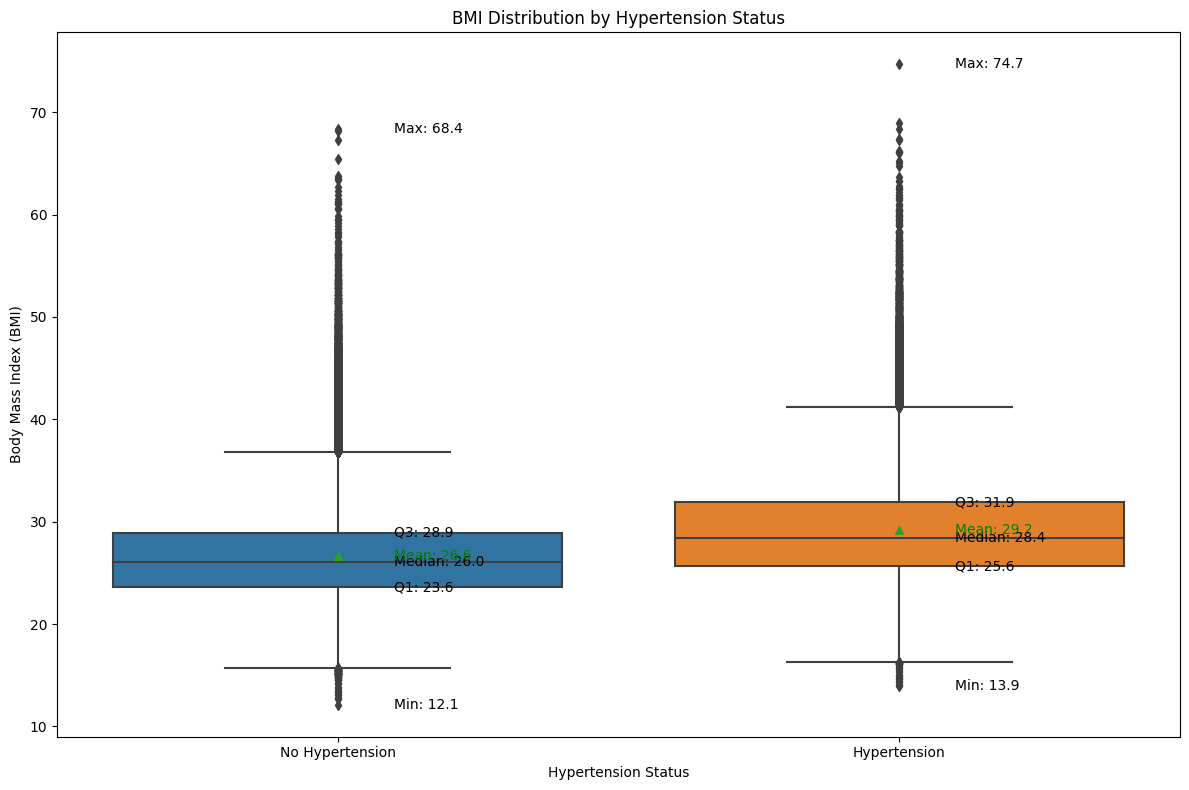

In [52]:
# BMI 
import seaborn as sns
import matplotlib.pyplot as plt

# Convert data types
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')  # Ensure BMI is numeric

# Drop rows with NaN values in BMI
df = df.dropna(subset=['BMI'])

# Plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='HTN_cc', y='BMI', data=df, showmeans=True)
plt.title('BMI Distribution by Hypertension Status')
plt.xlabel('Hypertension Status')
plt.ylabel('Body Mass Index (BMI)')
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'])

# Calculate statistics for each group
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['BMI']
    stats = group_data.describe()
    
    # Add text annotations
    ax.text(i + 0.1, stats['min'], f"Min: {stats['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'], f"Q1: {stats['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'], f"Median: {stats['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'], f"Q3: {stats['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'], f"Max: {stats['max']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['mean'], f"Mean: {stats['mean']:.1f}", ha='left', va='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()



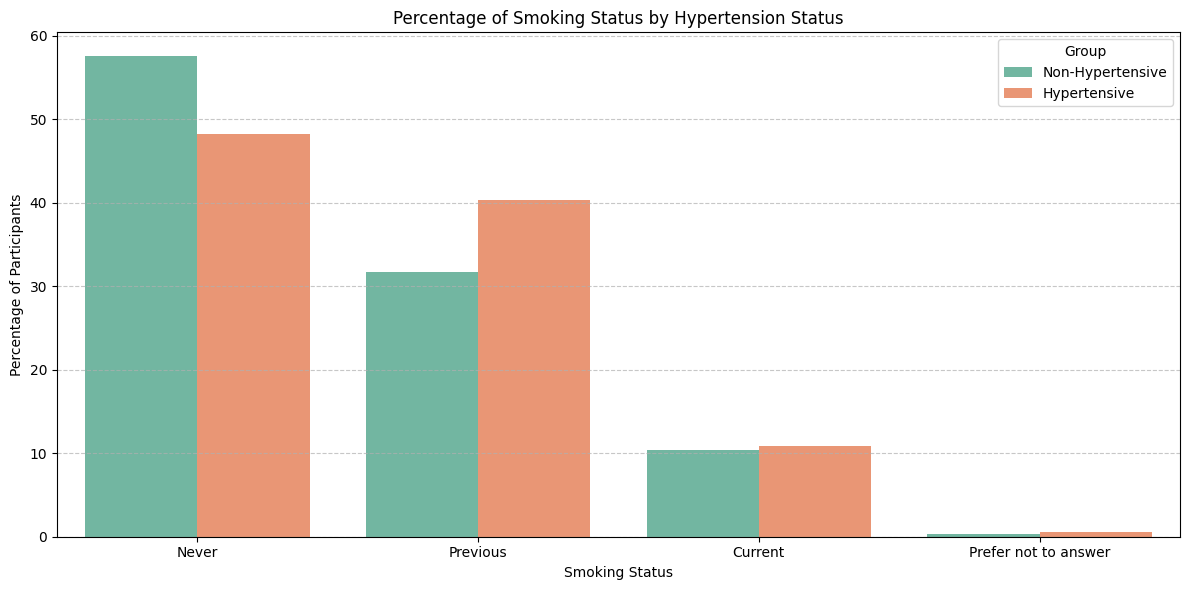

In [53]:
# smokig status 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data preparation (assuming df is your DataFrame)
# Filter for non-hypertensive patients
non_htn_df = df[df['HTN_cc'] == 0]
htn_df = df[df['HTN_cc'] == 1]

# Count occurrences of each smoking status
smoking_counts_non_htn = non_htn_df['smoking_status'].value_counts()
smoking_counts_htn = htn_df['smoking_status'].value_counts()

# Create a combined DataFrame
smoking_combined = pd.DataFrame({
    'Non-Hypertensive': smoking_counts_non_htn,
    'Hypertensive': smoking_counts_htn
}).fillna(0)  # Fill NaN values with 0

# Calculate percentages
smoking_percentages_combined = (smoking_combined.div(smoking_combined.sum(axis=0), axis=1)) * 100

# Reset index to use smoking statuses as a column
smoking_percentages_combined = smoking_percentages_combined.reset_index()
smoking_percentages_combined.columns = ['Smoking Status', 'Non-Hypertensive', 'Hypertensive']

# Create a bar chart
plt.figure(figsize=(12, 6))  # Set figure size

# Melt the DataFrame for seaborn compatibility
smoking_melted = smoking_percentages_combined.melt(id_vars='Smoking Status', var_name='Group', value_name='Percentage')

# Plotting the grouped bar chart using seaborn
sns.barplot(x='Smoking Status', y='Percentage', hue='Group', data=smoking_melted, palette='Set2')

# Add titles and labels
plt.title('Percentage of Smoking Status by Hypertension Status')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Participants')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


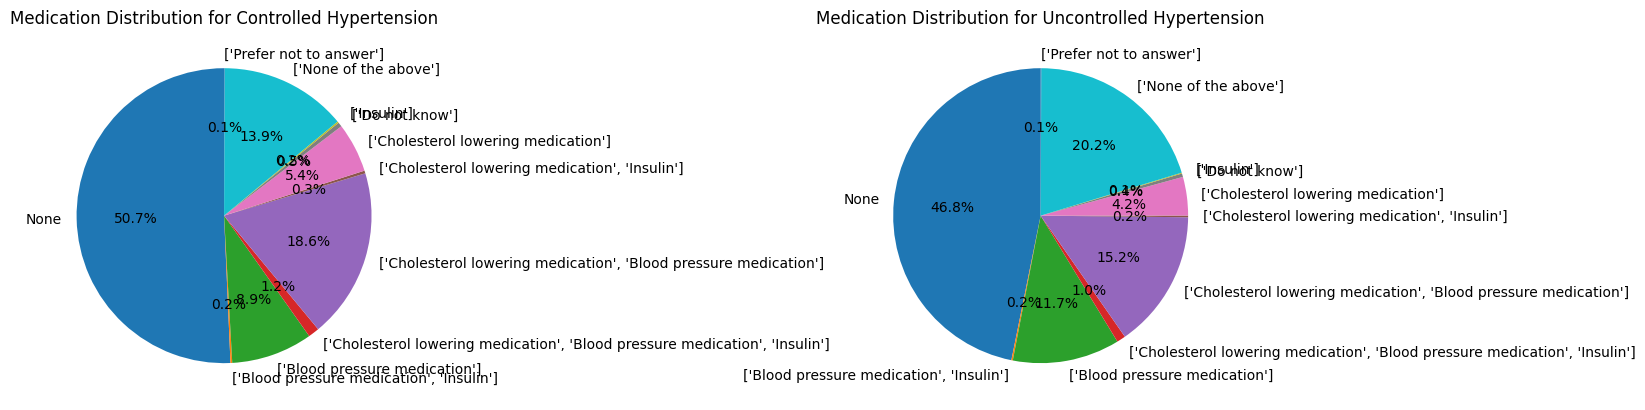

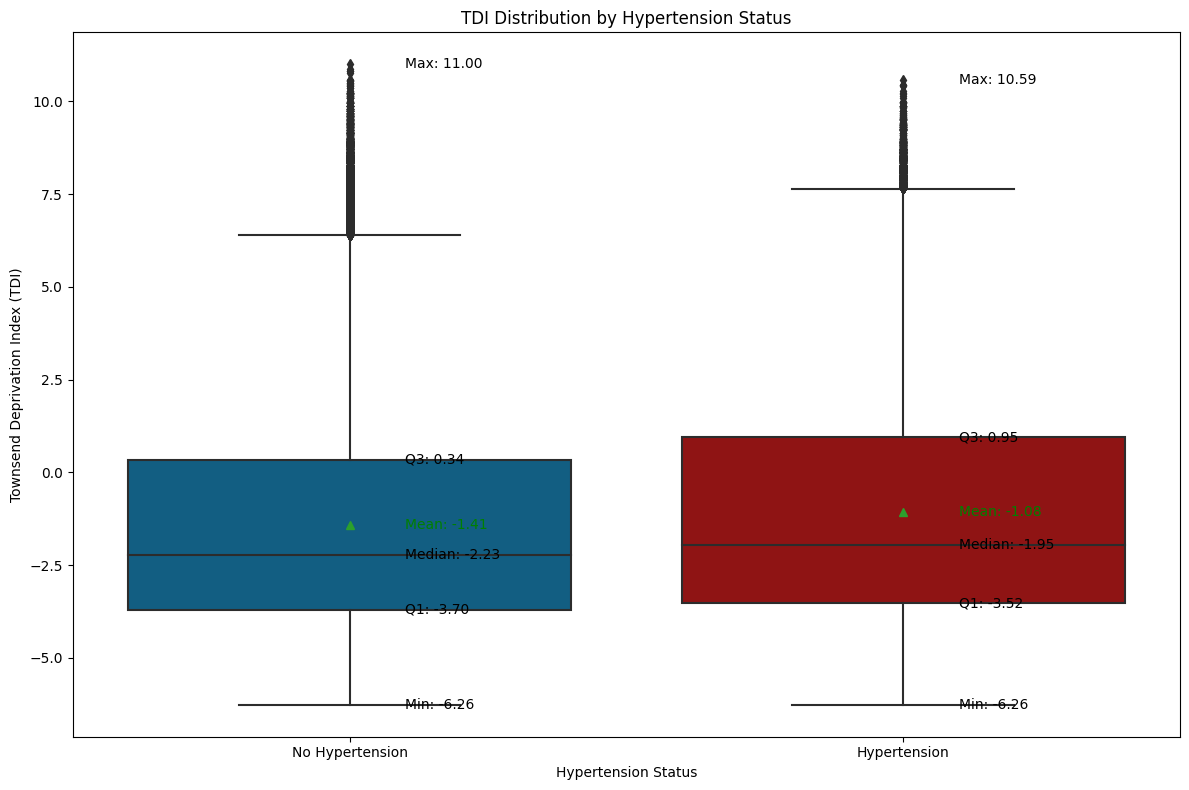

In [54]:
# medication by HTN control

import pandas as pd
import matplotlib.pyplot as plt

# Sample data preparation (assuming df is your DataFrame)
# Ensure 'Medication' is a categorical variable
df['Medication'] = df['Medication'].astype(str)

# Group by HTN control status and medication type to get counts
medication_counts = df.groupby(['HTN_Controlled', 'Medication']).size().unstack(fill_value=0)

# Create pie charts for each group with increased size
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Increased figure size

# Pie chart for Controlled Hypertension
axes[0].pie(medication_counts.loc['Controlled'], labels=medication_counts.columns, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Medication Distribution for Controlled Hypertension')

# Pie chart for Uncontrolled Hypertension
axes[1].pie(medication_counts.loc['Uncontrolled'], labels=medication_counts.columns, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Medication Distribution for Uncontrolled Hypertension')

plt.tight_layout()
plt.show()


# TDI
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert data types if necessary
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['tdi'] = pd.to_numeric(df['tdi'], errors='coerce')  # Ensure TDI is numeric

# Drop rows with NaN values in TDI
df = df.dropna(subset=['tdi'])

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the box plot with specified colors for HTN and Non-HTN
ax = sns.boxplot(x='HTN_cc', y='tdi', data=df, showmeans=True, palette={0: '#006494', 1: '#A30000'})

# Add titles and labels
plt.title('TDI Distribution by Hypertension Status')
plt.xlabel('Hypertension Status')
plt.ylabel('Townsend Deprivation Index (TDI)')
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'])  # Set x-tick labels

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['tdi']
    stats = group_data.describe()
    
    # Add text annotations for statistics
    ax.text(i + 0.1, stats['min'], f"Min: {stats['min']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'], f"Q1: {stats['25%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'], f"Median: {stats['50%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'], f"Q3: {stats['75%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'], f"Max: {stats['max']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['mean'], f"Mean: {stats['mean']:.2f}", ha='left', va='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()




In [55]:
# try bar chart instead

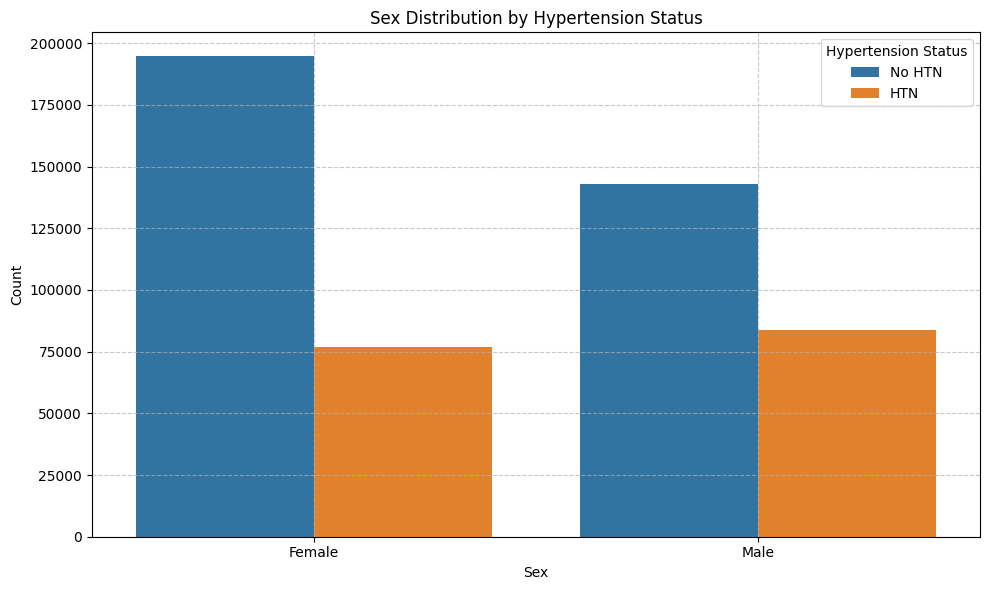

In [56]:
# sex by HTN 

plt.figure(figsize=(10, 6))
sns.countplot(x='sex', hue='HTN_cc', data=df)
plt.title('Sex Distribution by Hypertension Status')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Hypertension Status', labels=['No HTN', 'HTN'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

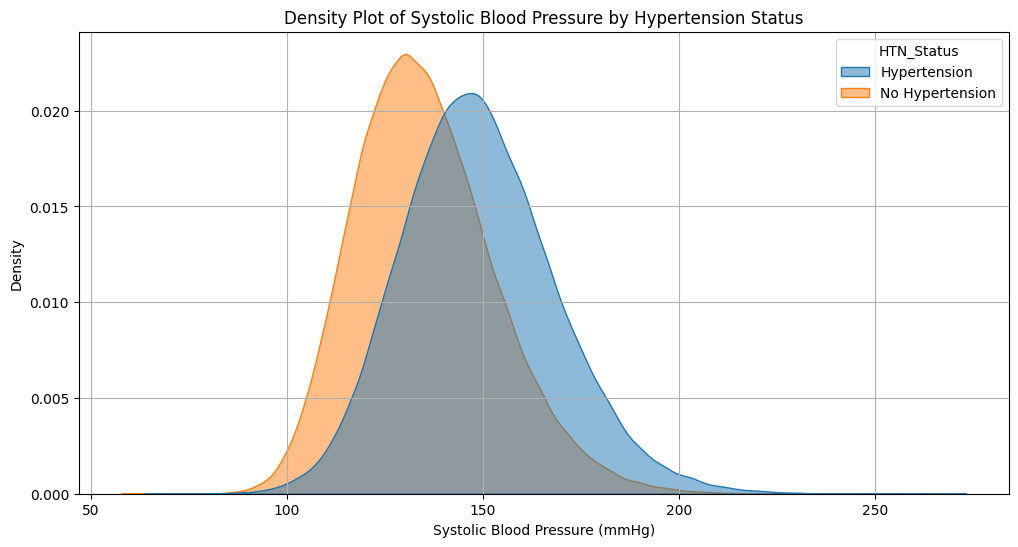

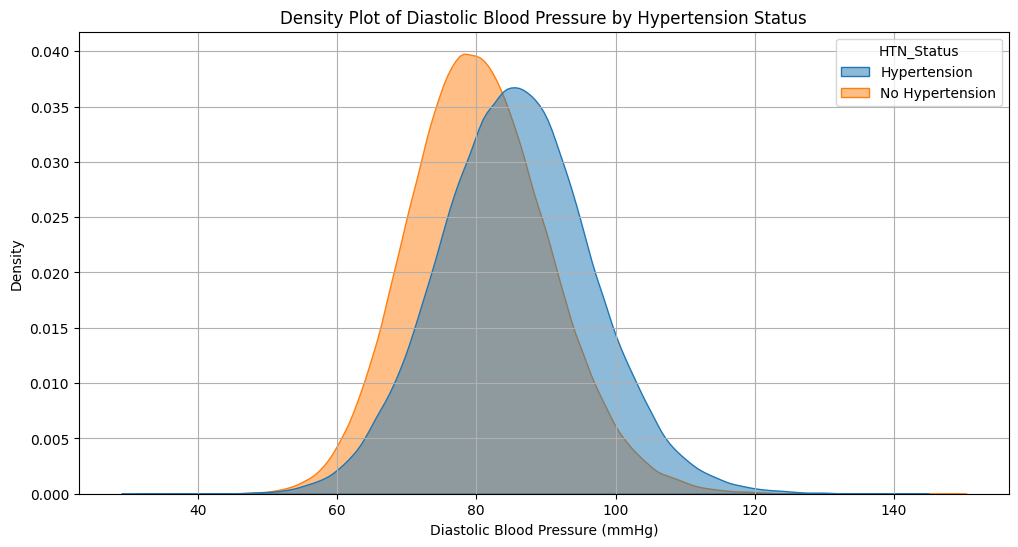

In [62]:
# density plots for SBP and DBP for HTN groups

import seaborn as sns
import matplotlib.pyplot as plt

df['SBP'] = pd.to_numeric(df['SBP'], errors='coerce')
df['DBP'] = pd.to_numeric(df['DBP'], errors='coerce')

df['HTN_Status'] = df['HTN_cc'].map({0: 'No Hypertension', 1: 'Hypertension'})

# figure for SBP
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='SBP', hue='HTN_Status', fill=True, common_norm=False, alpha=0.5)
plt.title('Density Plot of Systolic Blood Pressure by Hypertension Status')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# figure for DBP
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='DBP', hue='HTN_Status', fill=True, common_norm=False, alpha=0.5)
plt.title('Density Plot of Diastolic Blood Pressure by Hypertension Status')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

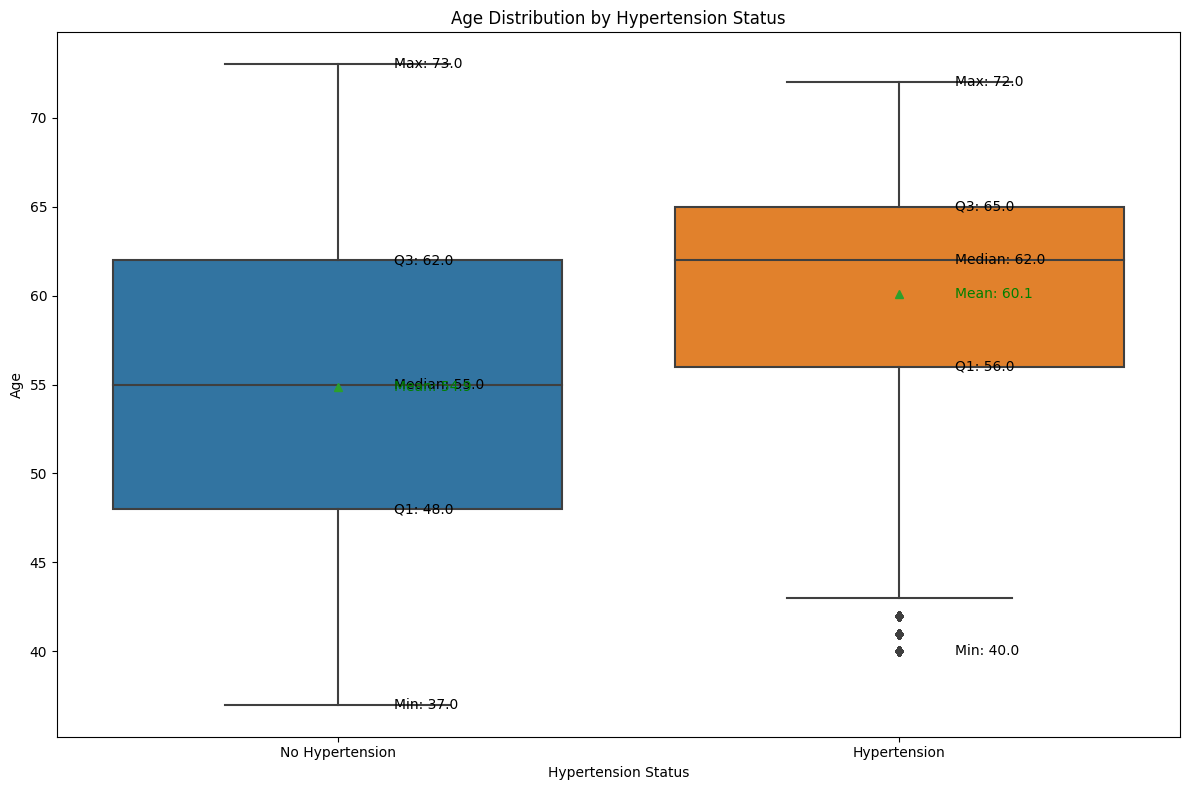

In [63]:
# age by HTN boxplot
import seaborn as sns
import matplotlib.pyplot as plt

#convert data type
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['age'] = df['age'].astype(float)

# Plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='HTN_cc', y='age', data=df, showmeans=True)
plt.title('Age Distribution by Hypertension Status')
plt.xlabel('Hypertension Status')
plt.ylabel('Age')
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'])

# Calculate statistics for each group
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['age']
    stats = group_data.describe()
    
    # Add text annotations
    ax.text(i + 0.1, stats['min'], f"Min: {stats['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'], f"Q1: {stats['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'], f"Median: {stats['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'], f"Q3: {stats['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'], f"Max: {stats['max']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['mean'], f"Mean: {stats['mean']:.1f}", ha='left', va='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()


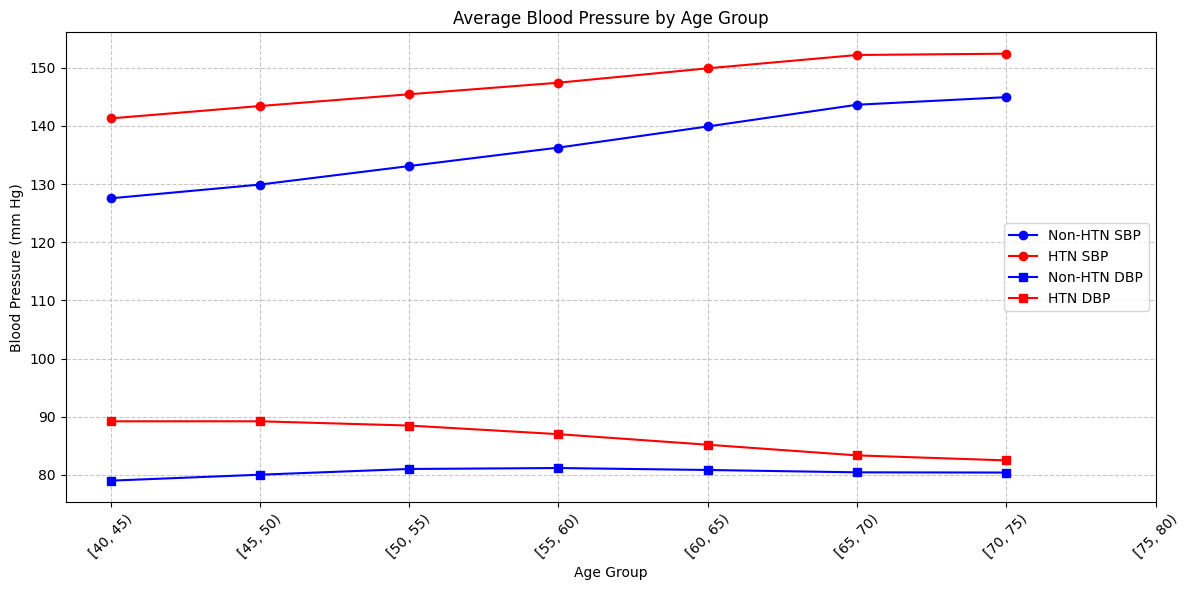

In [64]:
# BP by age  
import matplotlib.pyplot as plt
import pandas as pd

#convert to numeric 
df['SBP'] = pd.to_numeric(df['SBP'], errors='coerce')
df['DBP'] = pd.to_numeric(df['DBP'], errors='coerce')


# Create age groups
df['age_group'] = pd.cut(df['age'], bins=range(40, 85, 5), right=False)

# Calculate average BP for each age group and HTN status
avg_bp = df.groupby(['age_group', 'HTN_cc'])[['SBP', 'DBP']].mean().unstack()


# Create the plot
plt.figure(figsize=(12, 6))

# Plot SBP
plt.plot(range(len(avg_bp)), avg_bp['SBP'][0], color='blue', marker='o', label='Non-HTN SBP')
plt.plot(range(len(avg_bp)), avg_bp['SBP'][1], color='red', marker='o', label='HTN SBP')

# Plot DBP
plt.plot(range(len(avg_bp)), avg_bp['DBP'][0], color='blue', marker='s', label='Non-HTN DBP')
plt.plot(range(len(avg_bp)), avg_bp['DBP'][1], color='red', marker='s', label='HTN DBP')

plt.title('Average Blood Pressure by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Blood Pressure (mm Hg)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(avg_bp)), avg_bp.index.get_level_values('age_group').astype(str), rotation=45)

plt.tight_layout()
plt.show()



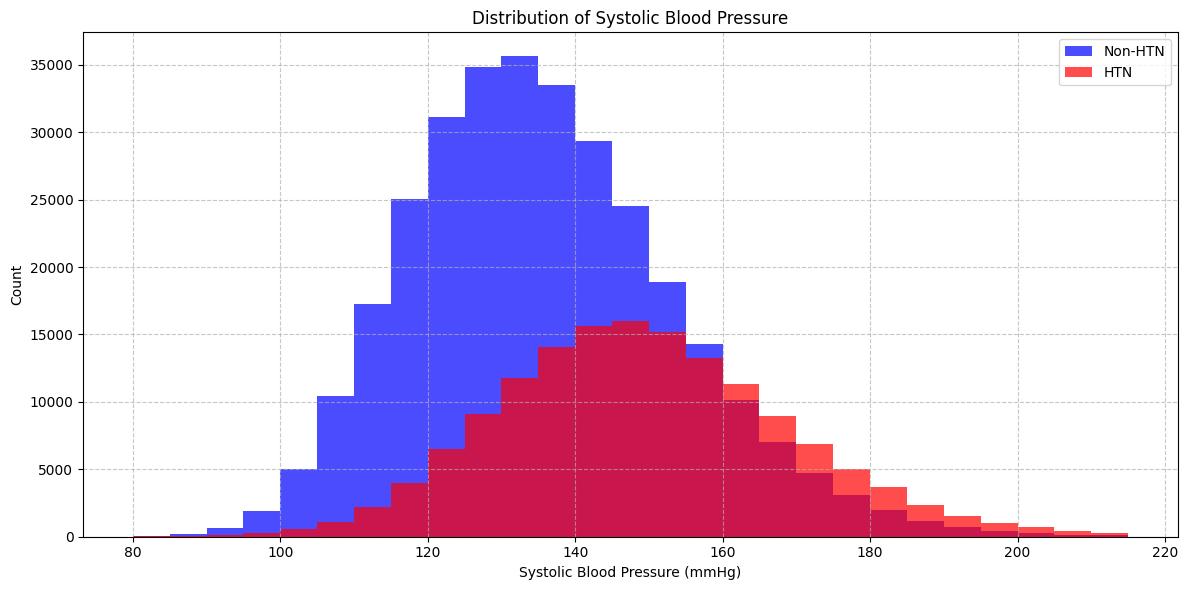

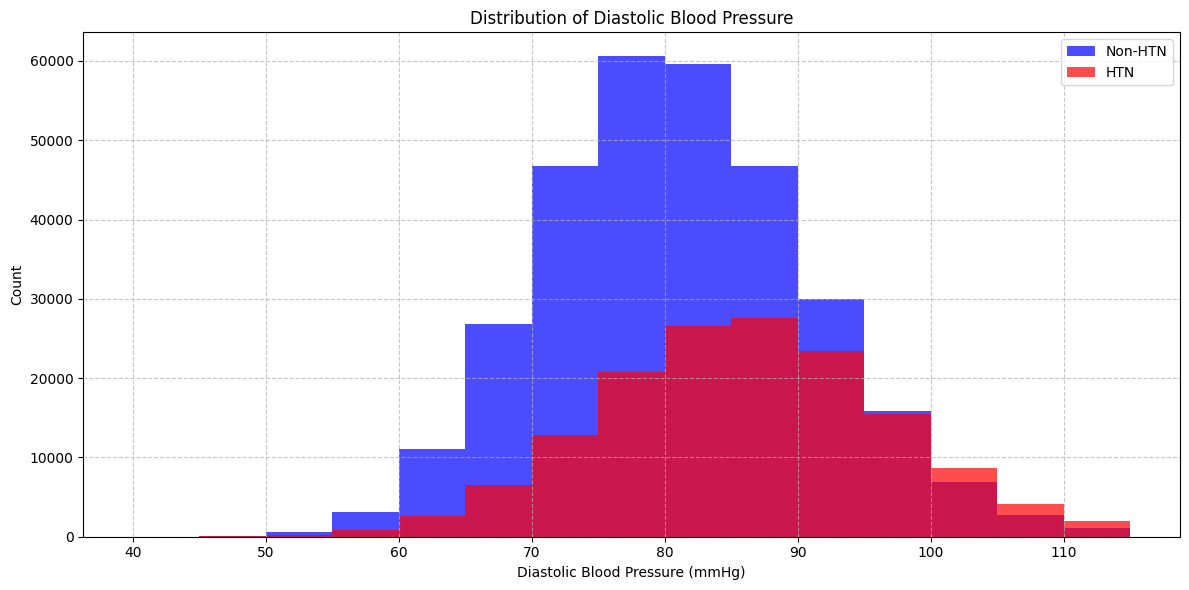

In [67]:
# SBP distribution HTN vs non HTN

import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with 'SBP' and 'HTN_cc' columns
plt.figure(figsize=(12, 6))

# Create histograms
plt.hist(df[df['HTN_cc'] == 0]['SBP'], bins=np.arange(80, 220, 5), alpha=0.7, color='blue', label='Non-HTN')
plt.hist(df[df['HTN_cc'] == 1]['SBP'], bins=np.arange(80, 220, 5), alpha=0.7, color='red', label='HTN')

plt.title('Distribution of Systolic Blood Pressure')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# DBP distribution HTN vs non HTN
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

plt.hist(df[df['HTN_cc'] == 0]['DBP'], bins=np.arange(40, 120, 5), alpha=0.7, color='blue', label='Non-HTN')
plt.hist(df[df['HTN_cc'] == 1]['DBP'], bins=np.arange(40, 120, 5), alpha=0.7, color='red', label='HTN')

plt.title('Distribution of Diastolic Blood Pressure')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



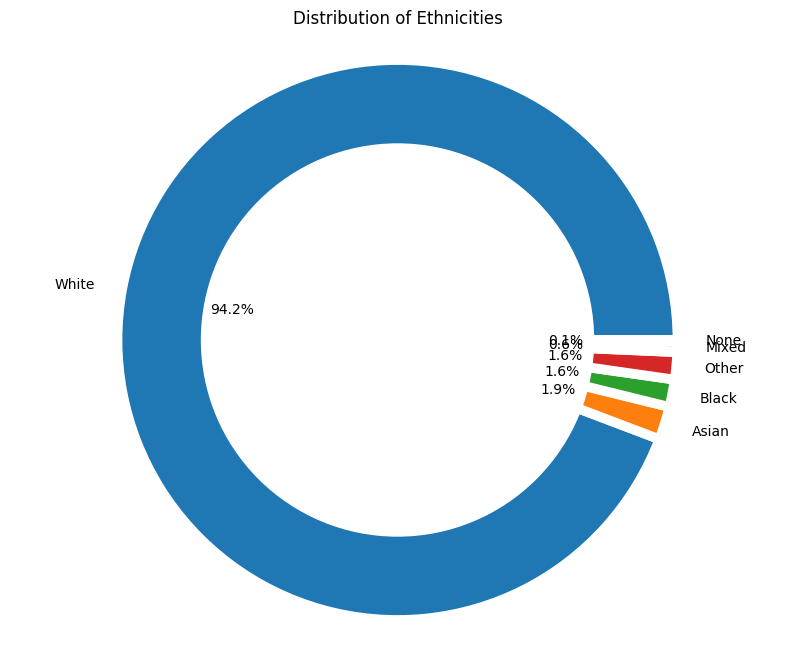

In [68]:
# ethnicity 
# library
import matplotlib.pyplot as plt

# Count the number of people in each ethnicity
ethnicity_counts = df['ethnicity'].value_counts()

# Create a circle at the center of the plot
my_circle = plt.Circle((0, 0), 0.7, color='white')

# Create pie chart with custom wedges
plt.figure(figsize=(10, 8))
plt.pie(ethnicity_counts.values, labels=ethnicity_counts.index, 
        wedgeprops={'linewidth': 7, 'edgecolor': 'white'}, 
        autopct='%1.1f%%')

# Add the circle to the pie chart
p = plt.gcf()
p.gca().add_artist(my_circle)

# Set title and display the plot
plt.title('Distribution of Ethnicities')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




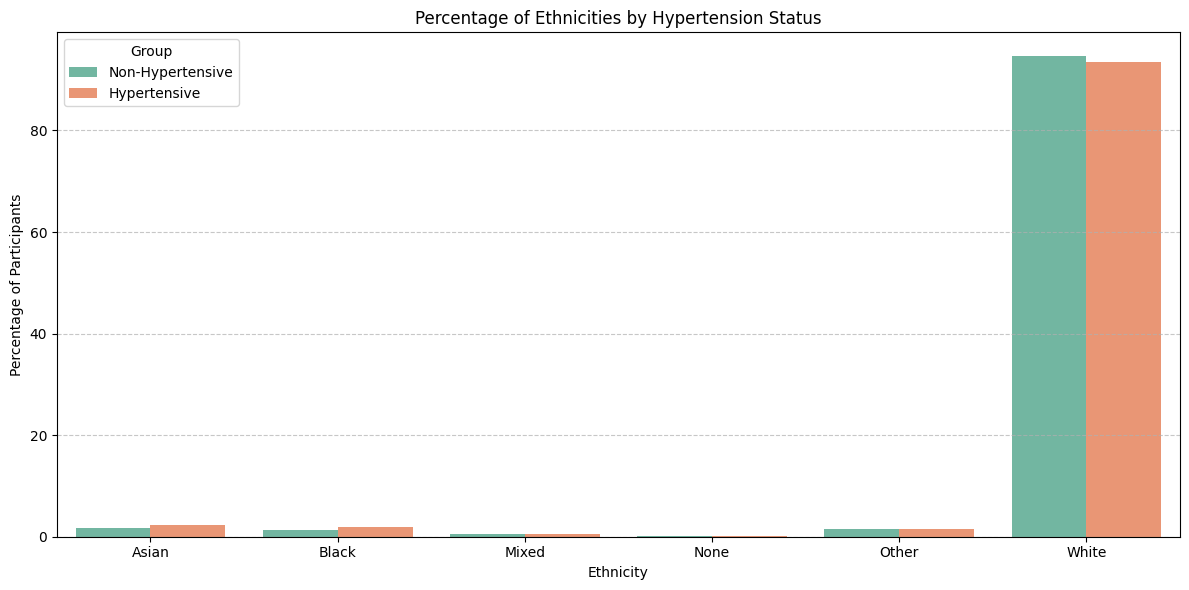

In [70]:
# ethnicities 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data preparation (assuming df is your DataFrame)
# Filter for non-hypertensive patients
non_htn_df = df[df['HTN_cc'] == 0]

# Filter for hypertensive patients
htn_df = df[df['HTN_cc'] == 1]

# Count occurrences of each ethnicity in both groups
ethnicity_counts_non_htn = non_htn_df['ethnicity'].value_counts()
ethnicity_counts_htn = htn_df['ethnicity'].value_counts()

# Create a combined DataFrame
ethnicity_combined = pd.DataFrame({
    'Non-Hypertensive': ethnicity_counts_non_htn,
    'Hypertensive': ethnicity_counts_htn
}).fillna(0)  # Fill NaN values with 0

# Calculate percentages
ethnicity_percentages_combined = (ethnicity_combined.div(ethnicity_combined.sum(axis=0), axis=1)) * 100

# Reset index to use ethnicities as a column
ethnicity_percentages_combined = ethnicity_percentages_combined.reset_index()
ethnicity_percentages_combined.columns = ['Ethnicity', 'Non-Hypertensive', 'Hypertensive']

# Create a bar chart
plt.figure(figsize=(12, 6))  # Set figure size

# Melt the DataFrame for seaborn compatibility
ethnicity_melted = ethnicity_percentages_combined.melt(id_vars='Ethnicity', var_name='Group', value_name='Percentage')

# Plotting the grouped bar chart using seaborn
sns.barplot(x='Ethnicity', y='Percentage', hue='Group', data=ethnicity_melted, palette='Set2')

# Add titles and labels
plt.title('Percentage of Ethnicities by Hypertension Status')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Participants')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
